# Exemple de Régression par les Moindres Carrés Pondérés (WLS)

La méthode canonique du paquet `statsmodels` pour l'ajustement des modèles de régression linéaire selon le critère des moindres carrés pondérés (WLS) est la méthode `WLS`.

Les paramètres à spécifier en arguments sont :
- `endog` : `array-like`
    >Une variable de réponse endogène sous forme d'objet compatible avec les arrays à une dimension `numpy`.

- `exog` : `array-like`
    >Un tableau $n\times k$ où $n$ est le nombre d'observations et $k$ est le nombre de régresseurs. Un terme *intercept* n'est pas inclus par défaut et doit être spécifié (au moyen de `add_constant`).

- `weights` : `array-like`
    >Un tableau à une dimension de poids. `WLS` exige que les pondérations soient proportionnelles à l'inverse de la variance de l'erreur. Si aucun poids n'est fourni, la valeur par défaut est 1 et les résultats sont les mêmes que ceux des moindres carrés ordinaires.

On commence par charger les paquets nécessaires, entre autres `matplotlib.pyplot` pour le traçage, `numpy` pour la manipulation des matrices et vecteurs et la génération aléatoire, ainsi que `pandas` pour le stockage des données.

In [20]:
# Affichage avec la bibliothèque graphique intégrée à Notebook
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy import stats

np.random.seed(31325)

## Estimation par Moindres Carrés Pondérés 

On utilise le modèle théorique $y_i=5+0.5x_i-0.01(x_i-5)^2+\varepsilon_i$ pour générer un échantillon de $n=100$ observations, où les $(\varepsilon_i)_i$ sont indépendants mais formant deux groupes homoscédastiques (à variance égale), un premier de $60$ observations avec une variance unitaire et le reste avec un écart-type égal à $3$.

In [22]:
n = 100
x = np.linspace(0, 20, n)
X = np.column_stack((x, (x - 5) ** 2))
X = sm.add_constant(X)
beta = [5.0, 0.5, -0.01]
sig = 0.5
w = np.ones(n)
w[n * 6 // 10 :] = 3
y_true = np.dot(X, beta)
e = np.random.normal(size=n)
y = y_true + sig * w * e


Dans cet exemple, `w` correspond à l'écart-type de l'erreur. La méthode `WLS` nécessite que les pondérations soient proportionnelles à l'inverse de la variance de l'erreur. L'array à passer en paramètre est donc `1/w**2`.

In [23]:
mod_wls = sm.WLS(y, X, weights=1.0 / (w ** 2))
res_wls = mod_wls.fit()
print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.897
Model:                            WLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     422.2
Date:                Sun, 01 Jan 2023   Prob (F-statistic):           1.35e-48
Time:                        21:12:35   Log-Likelihood:                -120.04
No. Observations:                 100   AIC:                             246.1
Df Residuals:                      97   BIC:                             253.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1178      0.129     39.536      0.0

À en croire le tableau résultant, $89\%$ de variabilité observée est expliquée par ce modèle selon le critère WLS. La qualité d'ajustement est corroborés par les estimations des paramètres limitrophes aux valeurs théoriques.

## OLS vs WLS

On s'apprête dans cette section à comparer l'ajustement du même modèle selon les deux critères étudiés jusqu'à présent : OLS et WLS. On commence par élaborer le résultat de l'ajustement par la méthode des moindres carrés ordinaires.

In [24]:
res_ols = sm.OLS(y, X).fit()
print(res_ols.params)
print(res_wls.params)

[ 5.07445654  0.49776306 -0.00839568]
[ 5.1177548   0.48098414 -0.00664632]


Les estimations des paramètres sont selon toute vraisemblance quasiment identiques.

Pour visualiser la différence, on calcule les intervalles de prédiction pour le modèle OLS au travers de la méthode `get_prediction()`. L'objet retourné comprend les valeurs supérieures et inférieures des intervalles de prédiction pour chaque observation ainsi que leurs barycentres.

In [39]:
pred_ols = res_ols.get_prediction()
# Borne Inférieure OLS
iv_i_ols = pred_ols.summary_frame()["obs_ci_lower"]
# Borne Supérieure OLS
iv_s_ols = pred_ols.summary_frame()["obs_ci_upper"]

On trace à présent les valeurs sans bruit, observées et les deux intervalles de prédiction pour chaque critère.

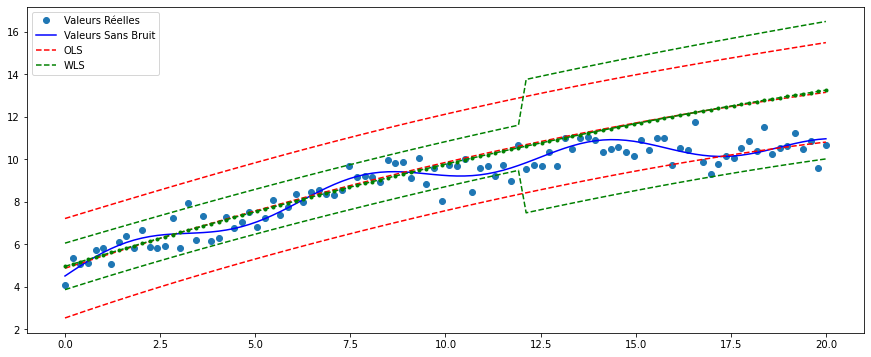

In [42]:
pred_wls = res_wls.get_prediction()
# Borne Inférieure WLS
iv_i = pred_wls.summary_frame()["obs_ci_lower"]
# Borne Supérieure WLS
iv_s = pred_wls.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(x, y, "o", label="Valeurs Réelles")
ax.plot(x, y_true, "b-", label="Valeurs Sans Bruit")
# OLS
ax.plot(x, res_ols.fittedvalues, "r--")
ax.plot(x, iv_s_ols, "r--", label="OLS")
ax.plot(x, iv_i_ols, "r--")
# WLS
ax.plot(x, res_wls.fittedvalues, "g--.")
ax.plot(x, iv_s, "g--", label="WLS")
ax.plot(x, iv_i, "g--")
ax.legend(loc="best")


```{admonition} Conclusion
:class: tip
Il s'avère que le critère des moindres carrés pondérés est plus adapté aux données présentant de l'hétéroscédasticité (variances non égales), dès lors que les moindres carrés ordinaires ne donnent pas une prévision exacte des valeurs avec des variances aberrantes (notamment le deuxième groupe d'observations avec un écart-type de 3) tandis que l'intervalle de prédiction WLS encapsule toutes les valeurs observées.
```